In [47]:
import os
import pandas as pd
import numpy as np
import keras
import keras_nlp
import tensorflow as tf

In [48]:
class CFG:
    """
    Configuration class to centralize hyperparameters.
    """
    # Model and data parameters
    preset = "deberta_v3_extra_small_en" # Name of pretrained models
    sequence_length = 512 # Example sequence length

    # Training parameters
    batch_size = 32 # Example batch size
    learning_rate = 5e-5 # Example learning rate
    epochs = 3 # Example number of epochs
    scheduler = 'cos' # Added scheduler attribute

    # Other parameters
    seed = 42 # Example random seed

    # Label mapping for winner models
    name2label = {"winner_model_a": 0, "winner_model_b": 1, "winner_tie": 2}

In [49]:
np.random.seed(CFG.seed)
tf.random.set_seed(CFG.seed)
print(f"Random seed set to {CFG.seed}")

Random seed set to 42


# Data Loading and Preprocessing

## Train Data

In [50]:
import ast

# Load Train Data
df = pd.read_csv('train.csv', engine='python', on_bad_lines='skip')

# Sample data
# df = df.sample(frac=0.10)

# Take the first prompt and its associated response
df["prompt"] = df.prompt.map(lambda x: ast.literal_eval(x)[0] if isinstance(x, str) else x)
df["response_a"] = df.response_a.map(lambda x: ast.literal_eval(x.replace("null","''"))[0] if isinstance(x, str) else x)
df["response_b"] = df.response_b.map(lambda x: ast.literal_eval(x.replace("null", "''"))[0] if isinstance(x, str) else x)

# Label conversion
df["class_name"] = df[["winner_model_a", "winner_model_b" , "winner_tie"]].idxmax(axis=1)
# Assuming CFG.name2label is defined elsewhere, if not, this will cause an error
df["class_label"] = df.class_name.map(CFG.name2label)

# Show Sample
display(df.head())

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,class_name,class_label
0,30192,gpt-4-1106-preview,gpt-4-0613,Is it morally right to try to have a certain p...,The question of whether it is morally right to...,"As an AI, I don't have personal beliefs or opi...",1,0,0,winner_model_a,0
1,53567,koala-13b,gpt-4-0613,What is the difference between marriage licens...,A marriage license is a legal document that al...,A marriage license and a marriage certificate ...,0,1,0,winner_model_b,1
2,65089,gpt-3.5-turbo-0613,mistral-medium,explain function calling. how would you call a...,Function calling is the process of invoking or...,Function calling is the process of invoking a ...,0,0,1,winner_tie,2
3,96401,llama-2-13b-chat,mistral-7b-instruct,How can I create a test set for a very rare ca...,Creating a test set for a very rare category c...,When building a classifier for a very rare cat...,1,0,0,winner_model_a,0
4,198779,koala-13b,gpt-3.5-turbo-0314,What is the best way to travel from Tel-Aviv t...,The best way to travel from Tel Aviv to Jerusa...,The best way to travel from Tel-Aviv to Jerusa...,0,1,0,winner_model_b,1


## Test Data

In [51]:
# Load Test Data
test_df = pd.read_csv('test.csv', engine='python', on_bad_lines='skip')

# Show Sample
display(test_df.head())

,id,prompt,response_a,response_b
0,136060,"[""I have three oranges today, I ate an orange ...","[""You have two oranges today.""]","[""You still have three oranges. Eating an oran..."
1,211333,"[""You are a mediator in a heated political deb...","[""Thank you for sharing the details of the sit...","[""Mr Reddy and Ms Blue both have valid points ..."
2,1233961,"[""How to initialize the classification head wh...","[""When you want to initialize the classificati...","[""To initialize the classification head when p..."


## Prompt-Response Pairs:

In [52]:
# Create prompt-response pairs
df['prompt_response_a'] = df['prompt'] + "\n" + df['response_a']
df['prompt_response_b'] = df['prompt'] + "\n" + df['response_b']

# Display a sample of the new columns
display(df[['prompt_response_a', 'prompt_response_b']].head())

,prompt_response_a,prompt_response_b
0,Is it morally right to try to have a certain p...,Is it morally right to try to have a certain p...
1,What is the difference between marriage licens...,What is the difference between marriage licens...
2,explain function calling. how would you call a...,explain function calling. how would you call a...
3,How can I create a test set for a very rare ca...,How can I create a test set for a very rare ca...
4,What is the best way to travel from Tel-Aviv t...,What is the best way to travel from Tel-Aviv t...


# Data Splitting and Dataloaders

In [53]:
from sklearn.model_selection import train_test_split

# Split the training data into training and validation sets
train_df, val_df = train_test_split(
    df,
    test_size=0.2,  # Example split ratio (20% for validation)
    random_state=CFG.seed,
    stratify=df['class_label'] # Stratify based on the target variable
)

print(f"Training set shape: {train_df.shape}")
print(f"Validation set shape: {val_df.shape}")

display(train_df.head())
display(val_df.head())

Training set shape: (45981, 13)
Validation set shape: (11496, 13)


,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,class_name,class_label,prompt_response_a,prompt_response_b
52106,3893859286,claude-2.1,gpt-4-0314,What is a foreign exchange crisis? What are so...,A foreign exchange crisis refers to a situatio...,"A foreign exchange crisis, also known as a cur...",0,1,0,winner_model_b,1,What is a foreign exchange crisis? What are so...,What is a foreign exchange crisis? What are so...
34245,2542800482,gpt4all-13b-snoozy,mpt-30b-chat,Describe to me the crab-eating macaque.,The crab-eating macaque is a species of Old Wo...,The crab-eating macaque (Macaca fascicularis) ...,0,1,0,winner_model_b,1,Describe to me the crab-eating macaque.\nThe c...,Describe to me the crab-eating macaque.\nThe c...
12344,915355120,vicuna-33b,claude-instant-1,solve for x: 100x = 104\/2 + 30. Think through...,To solve for x in the equation 100x = 104\/2 +...,"Okay, here are the step-by-step workings:\n\n1...",0,1,0,winner_model_b,1,solve for x: 100x = 104\/2 + 30. Think through...,solve for x: 100x = 104\/2 + 30. Think through...
17628,1317390939,gpt-4-0613,gpt-4-0314,Can I create an A-B trust without a lawyer?,"Yes, it is technically possible to create an A...","Yes, it is possible to create an A-B trust wit...",0,1,0,winner_model_b,1,Can I create an A-B trust without a lawyer?\nY...,Can I create an A-B trust without a lawyer?\nY...
22933,1706978920,mpt-30b-chat,llama-2-70b-chat,What are good metrics for evaluating the corre...,Evaluating the correctness of facts generated ...,Evaluating the correctness of facts generated ...,0,0,1,winner_tie,2,What are good metrics for evaluating the corre...,What are good metrics for evaluating the corre...


,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,class_name,class_label,prompt_response_a,prompt_response_b
28234,2098233919,claude-instant-1,gpt-3.5-turbo-0613,How many tires would you estimate are in the c...,I estimate there are over 1 million tires in t...,It is difficult to provide an exact estimate w...,1,0,0,winner_model_a,0,How many tires would you estimate are in the c...,How many tires would you estimate are in the c...
37422,2789033728,claude-instant-1,gpt-3.5-turbo-0613,Write KPI objectives and KPI strategies for M...,Here are some sample KPI objectives and strate...,KPI Objectives:\n1. Successfully migrate all c...,0,1,0,winner_model_b,1,Write KPI objectives and KPI strategies for M...,Write KPI objectives and KPI strategies for M...
56157,4198930172,koala-13b,vicuna-7b,Name all the skills of Disco Elysium and forma...,Skills of Disco Elysium:\n\n1. Persuasion - ...,"Sure, here are the skills in Disco Elysium, al...",0,0,1,winner_tie,2,Name all the skills of Disco Elysium and forma...,Name all the skills of Disco Elysium and forma...
32269,2396441388,dolphin-2.2.1-mistral-7b,starling-lm-7b-alpha,how do you do patch a hole in drywall?,Patching a hole in drywall involves a few step...,Patching a hole in drywall involves several st...,0,1,0,winner_model_b,1,how do you do patch a hole in drywall?\nPatchi...,how do you do patch a hole in drywall?\nPatchi...
48098,3592485435,pplx-70b-online,mixtral-8x7b-instruct-v0.1,John places his slice of pie in the refrigerat...,The refrigerator cannot communicate with John ...,The refrigerator does not have the ability to ...,0,0,1,winner_tie,2,John places his slice of pie in the refrigerat...,John places his slice of pie in the refrigerat...


In [54]:
preprocessor = keras_nlp.models.DebertaV3Preprocessor.from_preset(
    preset=CFG.preset, # Name of the model
    sequence_length=CFG.sequence_length, # Max sequence length, will be padded if shorter
)

print("Preprocessor initialized.")

Preprocessor initialized.


In [55]:
# Take a sample of the data to demonstrate the preprocessor output shape
sample_text = train_df['prompt_response_a'].iloc[:5]

# Apply the preprocessor
processed_output = preprocessor(sample_text)

# Print the shape of the output
print("Output shape of the preprocessing layer:", processed_output['token_ids'].shape)

Output shape of the preprocessing layer: (5, 512)


In [56]:
def preprocessing_fn(text, label):
    """
    Preprocessing function to tokenize and pad text data.
    """
    processed_text = preprocessor(text)
    return processed_text, label

## DataLoaders

In [57]:
def build_dataset(texts, labels=None, batch_size=32,
                  cache=True, shuffle=1024):
    AUTO = tf.data.AUTOTUNE  # AUTOTUNE option
    slices = (texts,) if labels is None else (texts, keras.utils.to_categorical(labels, num_classes=3))  # Create slices
    ds = tf.data.Dataset.from_tensor_slices(slices)  # Create dataset from slices
    ds = ds.cache() if cache else ds  # Cache dataset if enabled
    ds = ds.map(preprocess_fn, num_parallel_calls=AUTO)  # Map preprocessing function
    opt = tf.data.Options()  # Create dataset options
    if shuffle:
        ds = ds.shuffle(shuffle, seed=CFG.seed)  # Shuffle dataset if enabled
        opt.experimental_deterministic = False
    ds = ds.with_options(opt)  # Set dataset options
    ds = ds.batch(batch_size, drop_remainder=False)  # Batch dataset
    ds = ds.prefetch(AUTO)  # Prefetch next batch
    return ds  # Return the built dataset

# Model Definition

In [58]:
def build_classifier_model():
    # Load the backbone model
    backbone = keras_nlp.models.DebertaV3Backbone.from_preset(CFG.preset)

    # Create inputs for prompt_response_a and prompt_response_b
    # Each input needs token_ids and padding_mask
    input_a_token_ids = keras.Input(shape=(CFG.sequence_length,), dtype=tf.int32, name='input_a_token_ids')
    input_a_padding_mask = keras.Input(shape=(CFG.sequence_length,), dtype=tf.int32, name='input_a_padding_mask') # Use int32 for compatibility

    input_b_token_ids = keras.Input(shape=(CFG.sequence_length,), dtype=tf.int32, name='input_b_token_ids')
    input_b_padding_mask = keras.Input(shape=(CFG.sequence_length,), dtype=tf.int32, name='input_b_padding_mask') # Use int32 for compatibility


    # Process inputs through the shared backbone
    # We'll use the pooled output (classification token at index 0)
    output_a = backbone([input_a_token_ids, input_a_padding_mask])[:, 0]
    output_b = backbone([input_b_token_ids, input_b_padding_mask])[:, 0]

    # Combine the outputs (e.g., concatenation or subtraction)
    combined_output = keras.layers.concatenate([output_a, output_b])

    # Classification head
    # Add a dense layer and a dropout layer
    x = keras.layers.Dense(256, activation='relu')(combined_output)
    x = keras.layers.Dropout(0.2)(x)
    # Output layer for 3 classes (winner_model_a, winner_model_b, winner_tie)
    output = keras.layers.Dense(3, activation='softmax', name='output')(x)

    # Create the model
    model = keras.Model(inputs=[[input_a_token_ids, input_a_padding_mask], [input_b_token_ids, input_b_padding_mask]], outputs=output)

    return model

# Build the model
classifier_model = build_classifier_model()

# Print model summary
classifier_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_a_token_ids   │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_a_padding_ma… │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_b_token_ids   │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_b_padding_ma… │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ deberta_v3_backbone │ (None, 512, 384)  │ 70,682,112 │ input_a_token_id… │
│ (DebertaV3Backbone) │                   │            │ input_a_padding_… │
│                     │                   │            │ input_b_token_id… │
│                     │                   │            │ input_b_padding_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 384)       │          0 │ deberta_v3_backb… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 384)       │          0 │ deberta_v3_backb… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 768)       │          0 │ get_item_2[0][0], │
│ (Concatenate)       │                   │            │ get_item_3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    196,864 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_85          │ (None, 256)       │          0 │ dense_1[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 3)         │        771 │ dropout_85[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 70,879,747 (270.38 MB)

 Trainable params: 70,879,747 (270.38 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
# Compile the model
classifier_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=CFG.learning_rate),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()],
)

print("Model compiled.")

Model compiled.


In [60]:
# Train the model
print("Starting model training...")
history = classifier_model.fit(
    train_df,
    validation_data=val_df,
    epochs=CFG.epochs,
)

print("Model training finished.")

Starting model training...


ValueError: Invalid dtype: object

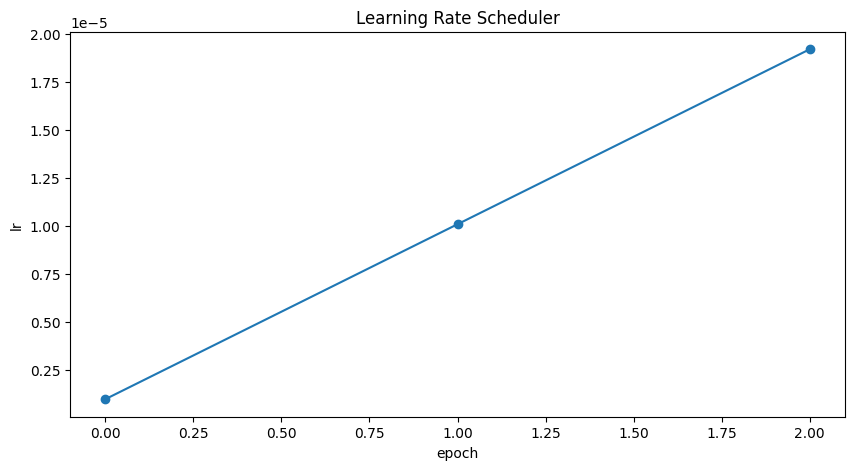

Starting model training...


ValueError: Invalid dtype: object

In [64]:
#==============================================================================
# Training
#
# This section defines the callbacks for the training loop and then starts the
# fine-tuning process for the model.
# ==============================================================================

# Note: This code assumes the 'CFG' class, 'model' object, 'train_ds',
#       and 'valid_ds' have been defined in previous sections.

# --- Define Learning Rate Scheduler Callback ---
# We will use a cosine learning rate schedule, which is often effective
# for fine-tuning tasks. The learning rate starts low, warms up, and then
# gradually decreases.
import math
import matplotlib.pyplot as plt # Import matplotlib for plotting

def get_lr_callback(batch_size=CFG.batch_size, mode=CFG.scheduler, epochs=CFG.epochs, plot=False):
    """
    Returns a learning rate scheduler callback.
    - 'batch_size', 'mode', and 'epochs' are taken from the CFG class.
    - If 'plot' is True, it will generate a plot of the learning rate schedule.
    """
    lr_start, lr_max, lr_min = 1.0e-6, 0.6e-6 * batch_size, 1e-6
    lr_ramp_ep, lr_sus_ep, lr_decay = 2, 0, 0.8

    def lrfn(epoch):
        """The core function that calculates the learning rate for each epoch."""
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        else:
            # Fallback for other modes if not implemented
            lr = lr_max
        return lr

    if plot:
        # Plot the learning rate curve to visualize the schedule
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('Learning Rate Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)

# Get the learning rate callback instance
lr_cb = get_lr_callback(CFG.batch_size, plot=True)


# --- Define Model Checkpoint Callback ---
# This callback will save the model's weights to a file whenever the validation
# log loss improves. This ensures we keep the best-performing model from all epochs.
ckpt_cb = keras.callbacks.ModelCheckpoint(f'best_model.weights.h5',
                                          monitor='val_log_loss', # Note: monitor metric might need adjustment based on your compilation
                                          save_best_only=True,
                                          save_weights_only=True,
                                          mode='min')


# --- Fit the Model (Start Training) ---
# Use the `model.fit()` method to begin the training process.
# We pass the training and validation datasets, the number of epochs, and our
# defined callbacks.
print("Starting model training...")
history = classifier_model.fit(
    train_df, # Corrected dataset name
    epochs=CFG.epochs,
    validation_data=val_df, # Corrected dataset name
    callbacks=[lr_cb, ckpt_cb]
)

print("Training complete. The best model weights are saved in 'best_model.weights.h5'.")